# Breast Cancer Dataset

In this notebook we will apply the LogitBoost algorithm to classify cases of breast cancer as benign or malignant.

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from logitboost import LogitBoost

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## Loading the data

The breast cancer dataset imported from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) contains $569$ samples with $30$ real, positive features (including cancer mass attributes like mean radius, mean texture, mean perimeter, et cetera).
Of the samples, $212$ are labeled "malignant" and $357$ are labeled "benign".
We load this data into a $569 \times 30$ feature matrix and a $569 \times 1$ target vector.
Then we randomly shuffle the data and designate two thirds for training and one third for testing.

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target_names[data.target]

# Shuffle data and split it into training/testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1. / 3),
                                                    shuffle=True, stratify=y,
                                                    random_state=0)

## Fitting the LogitBoost model

Next, we initialize a LogitBoost classifier and fit it to the training data.
By default, LogitBoost uses decision stumps as its base estimator.

In [3]:
lboost = LogitBoost(random_state=0)
lboost.fit(X_train, y_train)

LogitBoost(base_estimator=None, bootstrap=False, learning_rate=1.0,
      n_estimators=50, random_state=0, weight_trim_quantile=0.05,
      z_max=4.0)

## Prediction accuracy

As a first indicator of how well the model predicts the correct labels, we can check its accuracy score (number of correct predictions over the number of total predictions) on the training and test data.
If the classifier is good, then the accuracy score should be close to 1.

In [4]:
y_pred_train = lboost.predict(X_train)
y_pred_test = lboost.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Training accuracy: %.4f" % accuracy_train)
print("Testing accuracy:  %.4f" % accuracy_test)

Training accuracy: 0.9947
Testing accuracy:  0.9579


## Precision and Recall

We can also check LogitBoost's precision and recall.

In [5]:
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)
print("Training\n%s" % report_train)
print("Testing\n%s" % report_test)

Training
             precision    recall  f1-score   support

     benign       0.99      1.00      1.00       238
  malignant       1.00      0.99      0.99       141

avg / total       0.99      0.99      0.99       379

Testing
             precision    recall  f1-score   support

     benign       0.97      0.96      0.97       119
  malignant       0.93      0.96      0.94        71

avg / total       0.96      0.96      0.96       190



## Visualizing Accuracy During Boosting

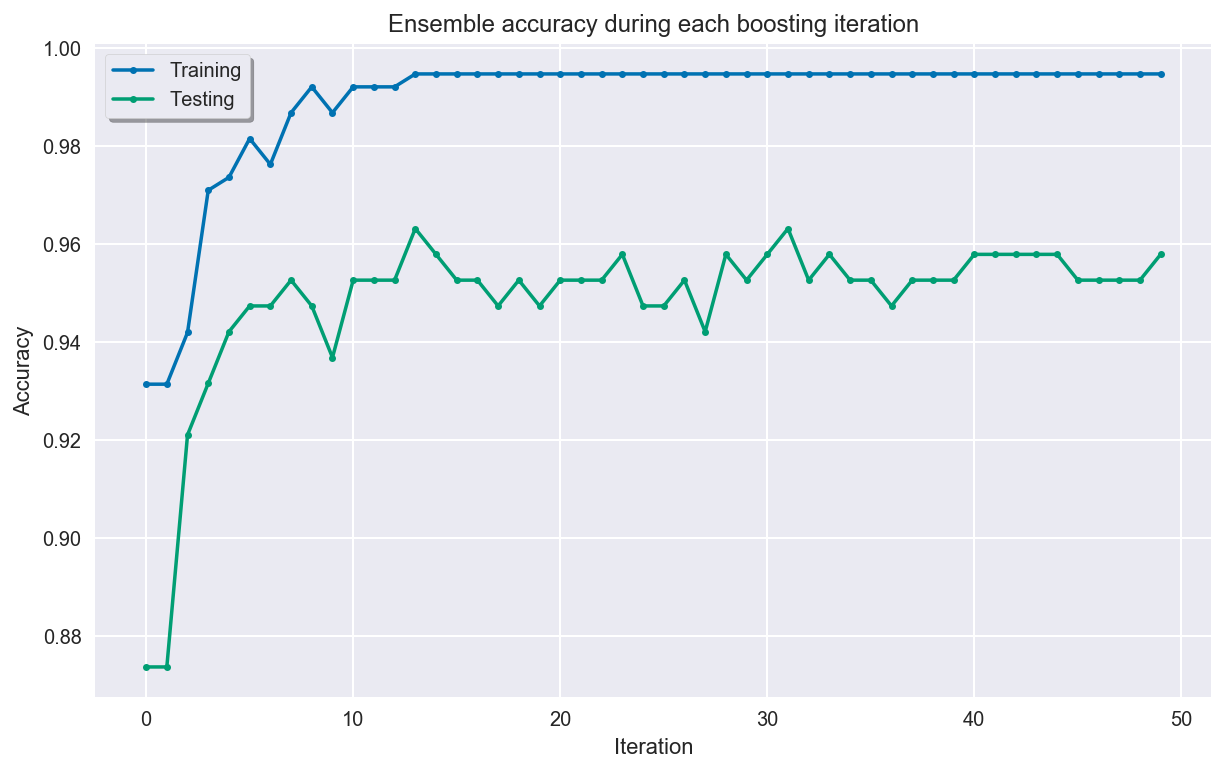

In [6]:
staged_accuracy_train = np.fromiter(lboost.staged_score(X_train, y_train),
                                    dtype=np.float64)
staged_accuracy_test = np.fromiter(lboost.staged_score(X_test, y_test),
                                   dtype=np.float64)

plt.figure(figsize=(10, 6))
plt.plot(staged_accuracy_train, label="Training", marker='.')
plt.plot(staged_accuracy_test, label="Testing", marker='.')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Ensemble accuracy during each boosting iteration")
plt.legend(loc="best", shadow=True, frameon=True)
plt.show()
plt.close()